In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from ray_families import GaussianFieldReconstructor, GaussianModeRayFamily, _cache_optimized_field_reconstruction

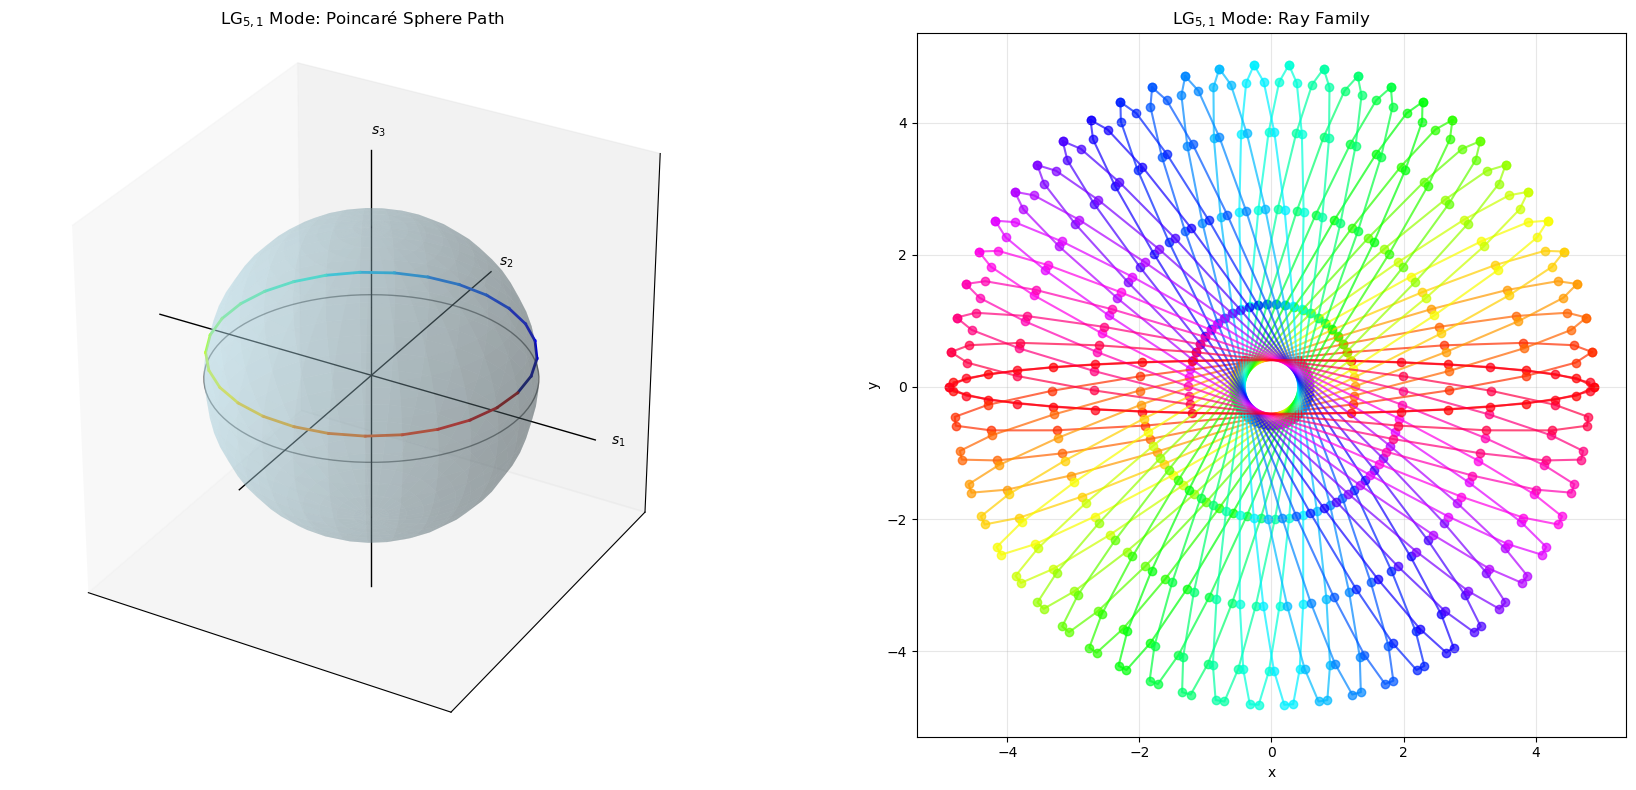

In [18]:
fig = plt.figure(figsize=(18, 8))

w = 2#10
k = 0.5# 2*np.pi/(780e-3)
# mode = GaussianModeRayFamily(mode_type='LG', N=3, mu=3, w0=w, k=k)
p=2
l=1
N = 2*p + abs(l)
mode = GaussianModeRayFamily(mode_type='LG', N=N, mu=l, w0=w, k=k)
# mode = GaussianModeRayFamily(mode_type='HG', N=N, mu=l, w0=w, k=k)

# Generate ray family
ray_family = mode.generate_ray_family(num_eta=30, num_tau=20)

# Calculate ROPL
ropl = mode.calculate_ROPL(ray_family)

# Plot Poincaré sphere
ax1 = fig.add_subplot(121, projection='3d')
mode.visualize_poincare_sphere(ray_family, ax=ax1)
ax1.set_title(f'{mode.mode_type}$_{{{mode.N},{mode.mu}}}$ Mode: Poincaré Sphere Path')

# Plot ray family
ax2 = fig.add_subplot(122)
mode.visualize_ray_family(ray_family, ax=ax2, arrow_length=0.0)
ax2.set_title(f'{mode.mode_type}$_{{{mode.N},{mode.mu}}}$ Mode: Ray Family')

plt.tight_layout()

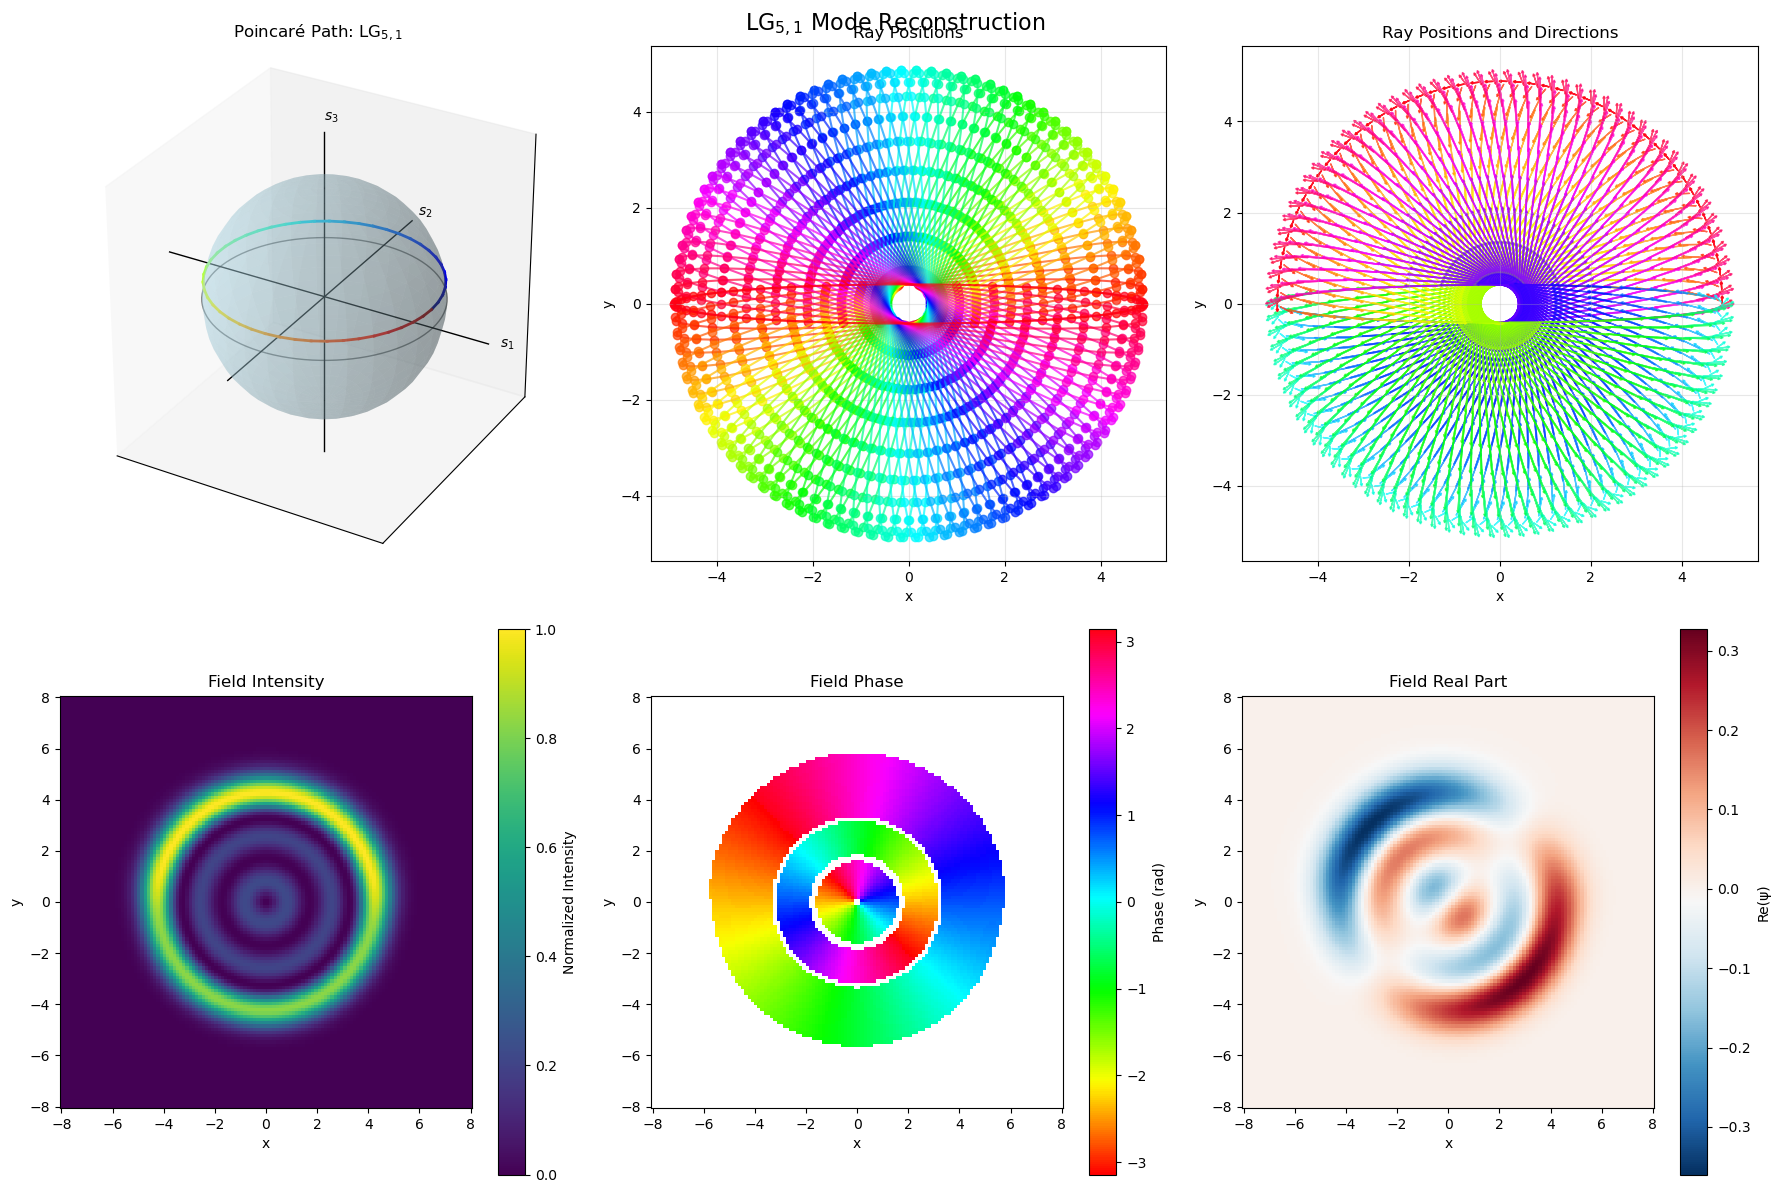

In [20]:

# Create reconstructor for the chosen mode
reconstructor = GaussianFieldReconstructor(mode)

# Full visualization
fig, field, x_grid, y_grid = reconstructor.visualize_all(grid_size=128, grid_extent=(-8, 8, -8, 8))

plt.show()

In [21]:
S, S1, S2, Gamma = mode.calculate_ROPL(ray_family)

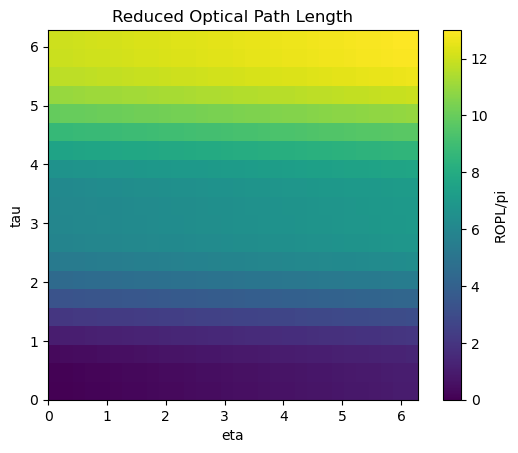

In [22]:
plt.figure()
# z in units of pi, also change colorbar to be in units of pi
plt.imshow((S.T/np.pi), extent=[0, 2*np.pi, 0, 2*np.pi], origin='lower')
plt.xlabel('eta')
plt.ylabel('tau')
plt.colorbar(label='ROPL/pi')
plt.title('Reduced Optical Path Length')
plt.show()

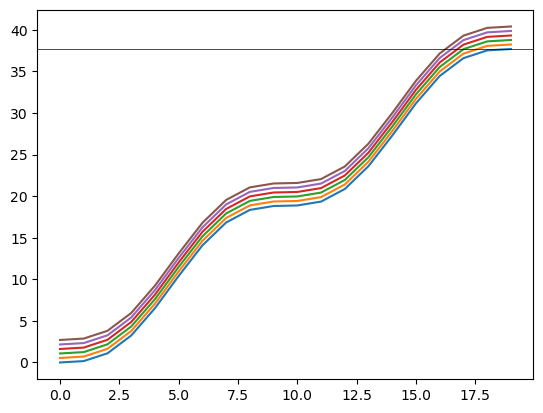

In [23]:
#S = np.zeros((num_eta, num_tau))
plt.figure()
for i in range(0, S.shape[0], 5):
    plt.plot(S[i,:]) # - S[i,0]
plt.axhline(y=2*np.pi*(mode.N+1), color='k', linewidth=0.5)
plt.show()


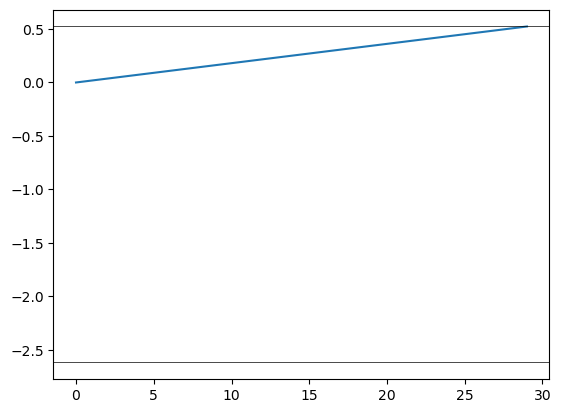

In [24]:
Omega = mode.solif_angle(mode.mu)
plt.figure()
plt.plot(Gamma)
plt.axhline(-0.5*Omega, color='k', linewidth=0.5)
plt.axhline(0.5*(2*np.pi-Omega), color='k', linewidth=0.5)
plt.show()

In [25]:
ray_family = mode.generate_ray_family(num_eta=40, num_tau=50)
# Extract parameters
ropl, _, _, _ = mode.calculate_ROPL(ray_family)

In [27]:
%matplotlib widget
from ipywidgets import *
import numpy as np
import k3d

import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from sloppy.optic import *
from sloppy.raytracing import *
from sloppy.abcd import *
from sloppy.utils import *
from sloppy.tools import *

In [28]:
def source_MLA_bundle(Nx=2, Ny=None, Nsx=5, Nsy=None, dx=0.5, dy=None, sx=1e-3, sy=None, Nex=0, Ney=None, ex=0, ey=None):
    if Ny is None:
        Ny = Nx

    if Nsy is None:
        Nsy = Nsx

    if dy is None:
        dy = dx

    if sy is None:
        sy = sx

    if Ney is None:
        Ney = Nex

    if ey is None:
        ey = ex

    # make iterators for x and y displacements and slopes and little epsilon displacements around MLA positions
    it_x = np.linspace(-dx*Nx, dx*Nx, 2*Nx+1) if Nx>0 else np.array([0])
    it_y = np.linspace(-dy*Ny, dy*Ny, 2*Ny+1) if Ny>0 else np.array([0])
    it_sx = np.linspace(-sx*Nsx, sx*Nsx, 2*Nsx+1) if Nsx>0 else np.array([0])
    it_sy = np.linspace(-sy*Nsy, sy*Nsy, 2*Nsy+1) if Nsy>0 else np.array([0])
    it_ex = np.linspace(-ex*Nex, ex*Nex, 2*Nex+1) if Nex>0 else np.array([0])
    it_ey = np.linspace(-ey*Ney, ey*Ney, 2*Ney+1) if Ney>0 else np.array([0])

    # iterate over all combinations of the iterators using itertools.product and make a bundle id for every x and y location
    mus = np.stack([[x+ex, y+ey, sx, sy] for x in it_x for y in it_y for sx in it_sx for sy in it_sy for ex in it_ex for ey in it_ey], axis=0)
    bundle_ids = np.stack([[i, j] for i, x in enumerate(it_x) for j, y in enumerate(it_y) for k, sx in enumerate(it_sx) for l, sy in enumerate(it_sy) for m, ex in enumerate(it_ex) for n, ey in enumerate(it_ey)], axis=0)


    return mus, bundle_ids

In [29]:
def cav(f=50.0, thick=4.0, eps=3.0, offset=0.0):

    ng = 1.4537
    R = (ng-1)*f
    
    nz = (0., 0. ,-1.0)
    nzm = (0., 0. ,1.0)
    axz = (-1, 0, 0)
    axzm = (1, 0, 0)

    p_grin_f = f
    p_grin_b = p_grin_f + thick
    p_long_f = p_grin_b + f - eps

    p00 = np.array([0,0,0])
    p0 = np.array([offset,0,p_grin_f])
    p1 = np.array([0,0,p_grin_b])
    p2 = np.array([0,0,p_long_f])

    ii = 25.4

    elements = [Screen(p=p00, n=nz, ax=axz, diameter=25.4),
                CurvedGlass(p=p0, n=nzm, ax=axzm, diameter=ii, R=R, curv='CC', n2=ng),
                Glass(p=p1, n=nzm, ax=axzm, diameter=ii, n1=ng),
                Screen(p=p2, n=nzm, ax=axzm, diameter=25.4)]
    
    return elements

In [59]:
elements = cav(eps=5.0, offset=0.0)

screen = elements[0]
sys = RaySystem(elements, add_screen=False)
sys.screen = screen


mu, bundle_id = source_MLA_bundle(Nx=5, Ny=0, Nsx=0, Nsy=0, dx=0.1, sx=1e-3, Nex=0, ex=10e-3)


# make the (i,j) bundle id a 1d array by adding i+j*Nx for every i,j pair
Nx = len(np.unique(bundle_id[:,0]))
bundle_ids = bundle_id[:,0] + bundle_id[:,1]*Nx

N = len(np.unique(bundle_ids))
viridis = plt.cm.viridis

# Extract N evenly spaced colors from viridis
colors = viridis(np.linspace(0, 1, N))

ray = sys.screen.eigenvectors_to_rays(mu)
traj = sys.propagate(ray, at_screen=False, clip=True)

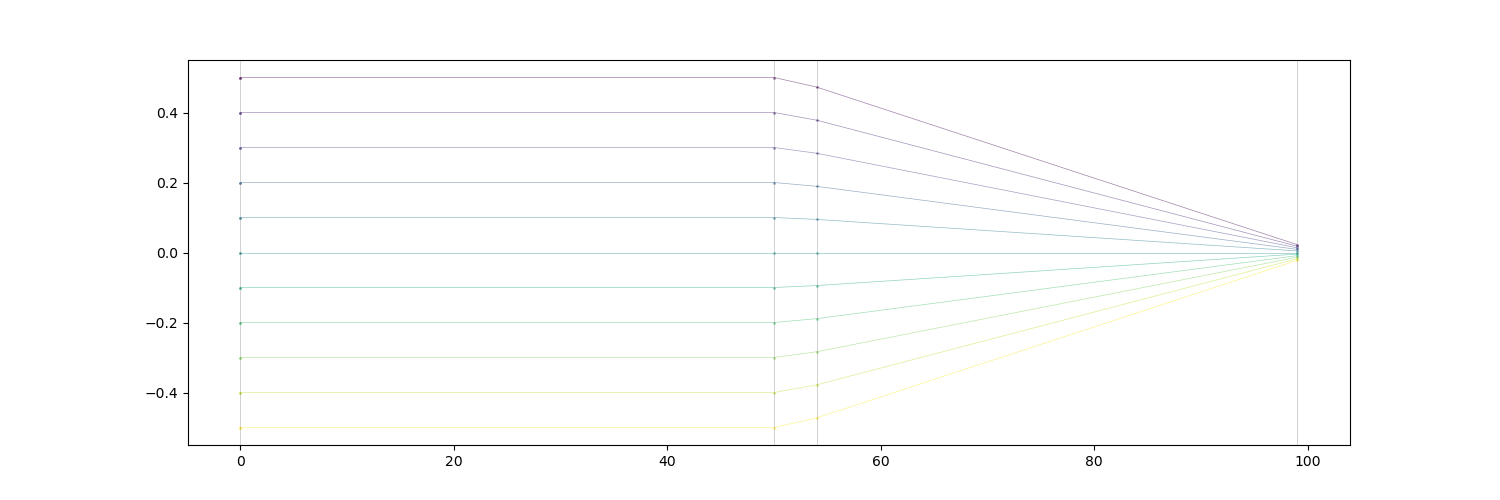

In [60]:
# make the plot
lines = []
fig, ax = plt.subplots(ncols=1, figsize=(15, 5))
plane = 'x'
k = 0 if plane == 'x' else 1
for i in range(traj.shape[2]):
    l = plt.plot(traj[:, 0, i, 2], traj[:, 0, i, k], color=colors[bundle_ids[i]], alpha=0.5, lw=0.5, marker='.', ms=2)[0]
    lines.append(l)

for el in elements:
    plt.axvline(el.p[2], color='grey', alpha=0.5, lw=0.5)
# plt.plot(traj_hit[:, 0, 0, 2], traj_hit[:, 0, 0, k], color='r', alpha=0.5, lw=0.5)[0]

In [61]:
traj.shape

(5, 2, 11, 3)

In [62]:
# measure the OPL
def opl_from_traj(traj):
    opls = traj[1:,0,:,:] - traj[:-1,0,:,:]
    return np.linalg.norm(opls, axis=-1)

In [63]:
opl = opl_from_traj(traj)

In [64]:
# we need to multiply the OPL by the index of refraction when it's in the glass
opl[1,:] *= 1.4537

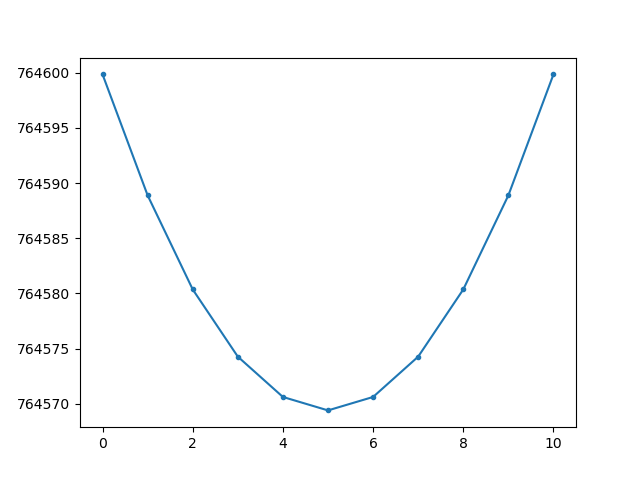

In [65]:
plt.figure()
plt.plot(np.sum(opl, axis=0)*mode.k, marker='.')
plt.show()

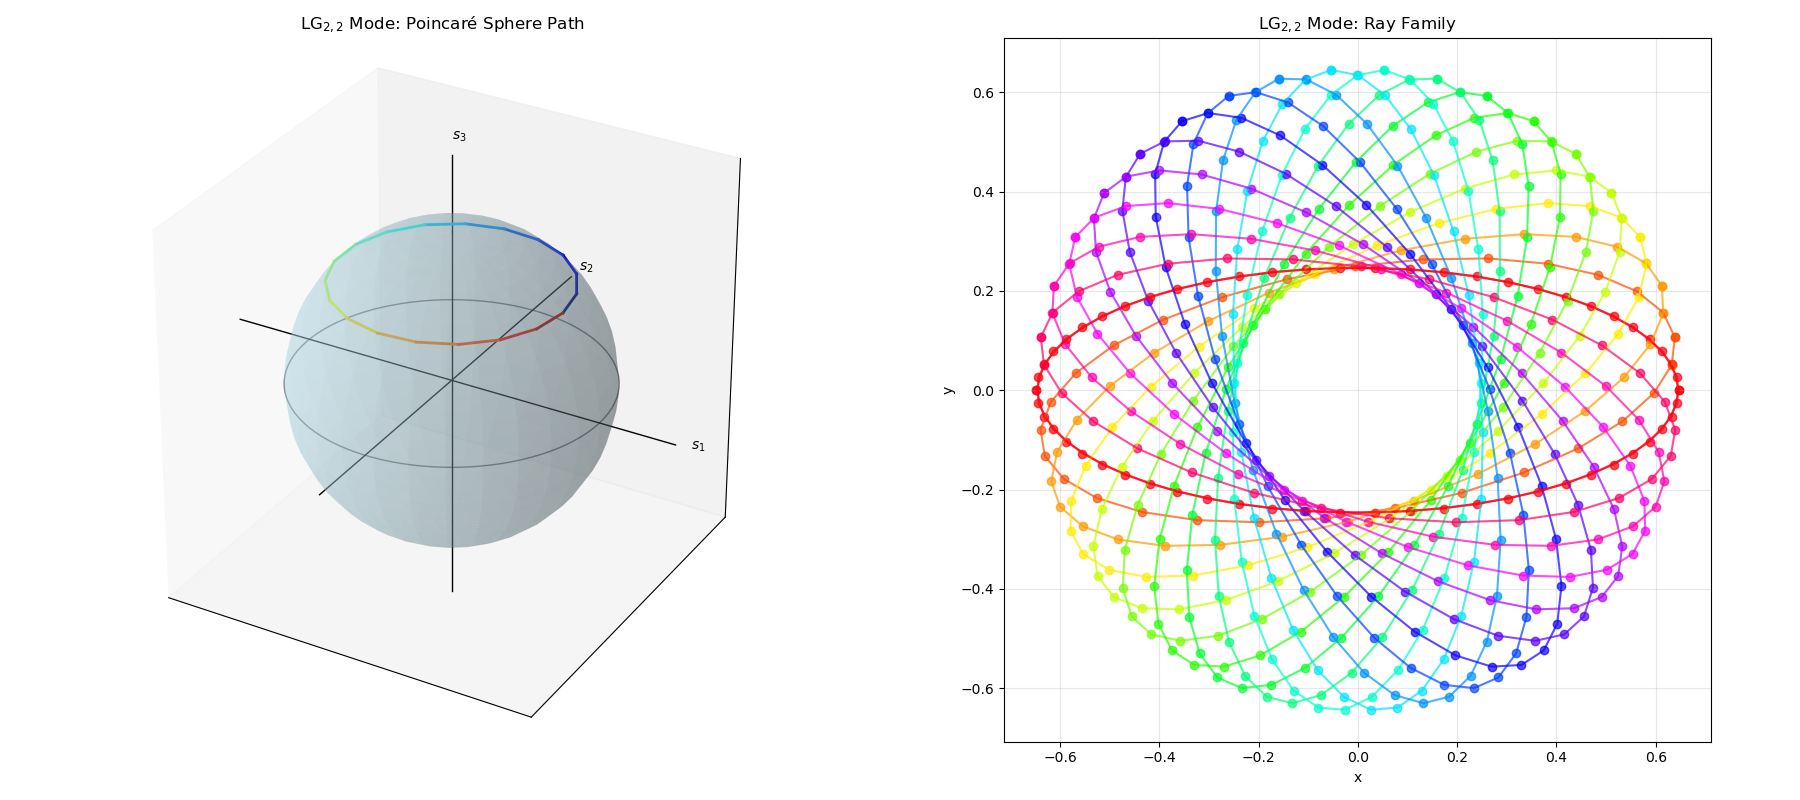

In [67]:
fig = plt.figure(figsize=(18, 8))

w = 0.4
k = 2*np.pi/(1e-3)

p=0
l=2
N = 2*p + abs(l)
mode = GaussianModeRayFamily(mode_type='LG', N=N, mu=l, w0=w, k=k)

# Generate ray family
ray_family = mode.generate_ray_family(num_eta=20, num_tau=30)

# Calculate ROPL
ropl, _, _, _ = mode.calculate_ROPL(ray_family)

# Plot Poincaré sphere
ax1 = fig.add_subplot(121, projection='3d')
mode.visualize_poincare_sphere(ray_family, ax=ax1)
ax1.set_title(f'{mode.mode_type}$_{{{mode.N},{mode.mu}}}$ Mode: Poincaré Sphere Path')

# Plot ray family
ax2 = fig.add_subplot(122)
mode.visualize_ray_family(ray_family, ax=ax2, arrow_length=0.0)
ax2.set_title(f'{mode.mode_type}$_{{{mode.N},{mode.mu}}}$ Mode: Ray Family')

plt.tight_layout()

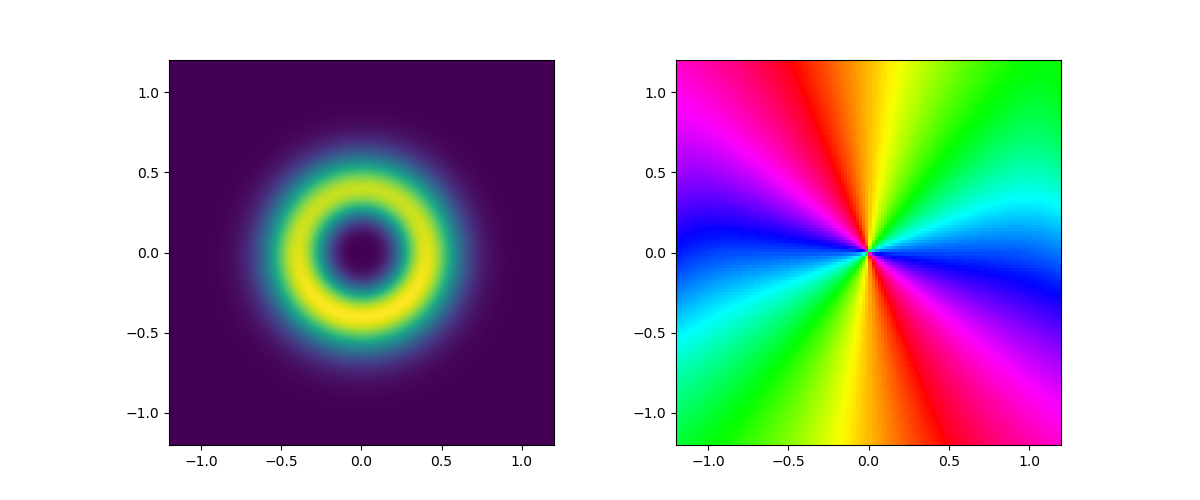

In [68]:

a = w*3.0
# %%timeit
field_nb = _cache_optimized_field_reconstruction(positions = ray_family['positions'],
                                                momenta = ray_family['momenta'],
                                                eta_values = ray_family['eta_values'],
                                                tau_values = ray_family['tau_values'],
                                                phi_values = ray_family['phi_of_eta_values'],
                                                theta_values = ray_family['vartheta_of_eta_values'],
                                                ropl=ropl,
                                                grid_extent=[-a, a, -a, a],
                                                grid_size=128,
                                                k=mode.k,
                                                sigma=mode.w0
                                                )

f, ax = plt.subplots(ncols=2, figsize=(12,5))

ax[0].imshow(np.abs(field_nb)**2, interpolation='bilinear', extent=[-a, a, -a, a])
ax[1].imshow(np.angle(field_nb), cmap='hsv', extent=[-a, a, -a, a])

In [69]:
orig_shape = ray_family['positions'].shape
# stack positions and momenta into paraxial eigenvectors mu
# mu = np.array([1e-1, 0., 0., 1e-3])
mus = np.concatenate([ray_family['positions'].reshape((-1,2)), ray_family['momenta'].reshape((-1,2))], axis=-1)


In [70]:
ray = sys.screen.eigenvectors_to_rays(mus)
traj = sys.propagate(ray, at_screen=False, clip=True)

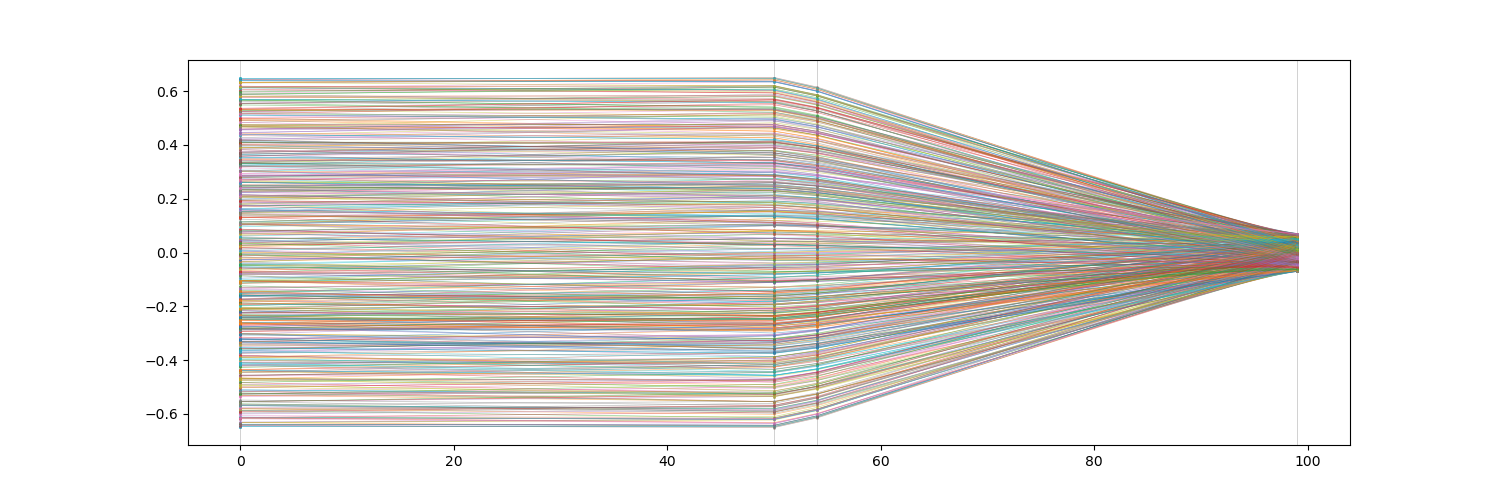

In [71]:
# make the plot
lines = []
fig, ax = plt.subplots(ncols=1, figsize=(15, 5))
plane = 'x'
k = 0 if plane == 'x' else 1
for i in range(traj.shape[2]):
    l = plt.plot(traj[:, 0, i, 2], traj[:, 0, i, k], alpha=0.5, lw=0.5, marker='.', ms=2)[0]
    lines.append(l)

for el in elements:
    plt.axvline(el.p[2], color='grey', alpha=0.5, lw=0.5)
# plt.plot(traj_hit[:, 0, 0, 2], traj_hit[:, 0, 0, k], color='r', alpha=0.5, lw=0.5)[0]

[]

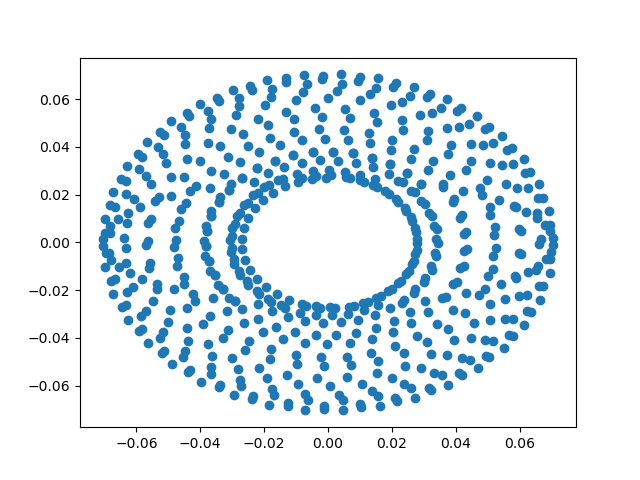

In [73]:
plt.figure()
el=4
plt.scatter(traj[el,0,:,0], traj[el,0,:,1])
plt.plot()

In [74]:
# turn rays back into eigenvectors
mus_out = sys.elements[el-1].rays_to_eigenvectors(traj[el,:,:,:])
mus_out.shape


(600, 4)

In [75]:
pos_out = mus_out[:,:2].reshape(orig_shape)
mom_out = mus_out[:,2:].reshape(orig_shape)

In [76]:
opl = opl_from_traj(traj)
opl[1,:] *= 1.4537
opl = np.sum(opl, axis=0)

In [77]:
ropl.shape

(20, 30)

In [78]:
# added action because of propagation
Stot = ropl + mode.k*opl.reshape(orig_shape[:-1])

In [88]:

# %%timeit
# b = a*0.2  
ratio = np.max(traj[el,0,:,:2])/np.max(traj[0,0,:,:2])
b = a*ratio
field_nb = _cache_optimized_field_reconstruction(positions = pos_out,
                                                momenta = mom_out,
                                                eta_values = ray_family['eta_values'],
                                                tau_values = ray_family['tau_values'],
                                                phi_values = ray_family['phi_of_eta_values'],
                                                theta_values = ray_family['vartheta_of_eta_values'],
                                                ropl=Stot,
                                                grid_extent=[-b, b, -b, b],
                                                grid_size=128,
                                                k=mode.k,
                                                sigma=mode.w0*ratio
                                                )

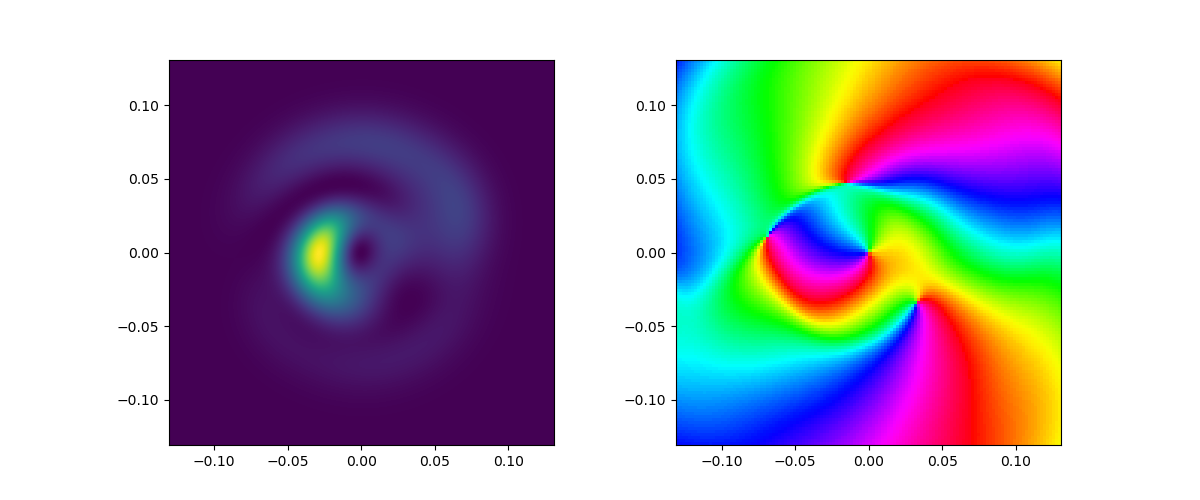

In [89]:
f, ax = plt.subplots(ncols=2, figsize=(12,5))

ax[0].imshow(np.abs(field_nb)**2, interpolation='bilinear', extent=[-b, b, -b, b])
ax[1].imshow(np.angle(field_nb), cmap='hsv', extent=[-b, b, -b, b])

0.10904814379362403